In [ ]:
!pip install open_clip_torch
!wget https://zenodo.org/records/10446026/files/CLIPAG_ViTB32.pt

Use ViT like model to process images and perform neural regress. 

In [10]:
import open_clip
from os.path import join
import torch

ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
data = torch.load(join(ckpt_dir, 'CLIPAG_ViTB32.pt'), map_location='cpu')
data = data['state_dict']
data = {k.replace('module.', ''): v for k, v in data.items()}

model_clip, _, preprocess = open_clip.create_model_and_transforms('ViT-B/32',device="cuda")
model_clip.load_state_dict(data)
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model_clip.visual.eval().to(device)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model_clip.visual.eval().to(device)

In [12]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x15389d515a20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [14]:
model

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

### Fit encoding models for vision transformer

In [15]:
%load_ext autoreload
%autoreload 2

In [30]:
import sys
sys.path.append(r"/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import os
from os.path import join
import torch as th
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from circuit_toolkit.plot_utils import show_imgrid
from circuit_toolkit.layer_hook_utils import featureFetcher
from circuit_toolkit.dataset_utils import ImagePathDataset, DataLoader
from circuit_toolkit.plot_utils import saveallforms
from core.data_utils import load_neural_data, load_from_hdf5, parse_image_fullpaths
from core.model_load_utils import load_model_transform
from neural_regress.regress_lib import record_features, perform_regression_sweeplayer, perform_regression_sweeplayer_RidgeCV
from neural_regress.regress_eval_lib import format_result_df, plot_result_df_per_layer, construct_result_df_masked, \
    compute_pred_dict_D2_per_unit

In [ ]:
# device = "cuda" if th.cuda.is_available() else "cpu"
# dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
# data_path = join(dataroot, "nsd_shared1000_6monkeys_2024.h5")
# stimroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/Stimuli/shared1000"
# # Load data
# data = load_from_hdf5(data_path)
# print("subjects:", list(data.keys()))

In [20]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"

In [18]:
stimuli_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Stimuli"
ephys_root = "/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Ephys_Data"

data_path = join(ephys_root, "vvs-accentuate-day1_normalize_red_20241212-20241220.h5")
# datapath_day3 = join(ephys_root, "vvs_accentuate_day3_normalize_red_20250123-20250126.hdf5")

imgdir_shared = join(stimuli_root, "shared1000")
imgdir = join(stimuli_root, "stimuli_pilot_20241119/results")
# imgdir_day3 = join(stimuli_root, "results_12-01-2025")
data = load_from_hdf5(data_path)
print("subjects:", list(data.keys()))

In [21]:
subject_id = 'red_20241212-20241220'
data_dict = load_neural_data(data_path, subject_id, None)
data_dict['image_fps'] = parse_image_fullpaths(data_dict["stimulus_names"], [imgdir_shared, imgdir])
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']
figdir = join(dataroot, subject_id, "model_outputs")
os.makedirs(figdir, exist_ok=True)

All stimulus files were found


In [28]:
batch_size = 96
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
# for modelname in ["clipag_vitb32", ]: # 
modelname = "clipag_vitb32"

ckpt_dir = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_backbones'
data = torch.load(join(ckpt_dir, 'CLIPAG_ViTB32.pt'), map_location='cpu')
data = data['state_dict']
data = {k.replace('module.', ''): v for k, v in data.items()}

model_clip, _, transforms_pipeline = open_clip.create_model_and_transforms('ViT-B/32',device="cuda")
model_clip.load_state_dict(data)
model = model_clip.visual.eval().to(device)
# tokenizer = open_clip.get_tokenizer('ViT-B-32')

# model, transforms_pipeline = load_model_transform(modelname, device=device)
# Prepare dataset with transforms
dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
# Prepare fetcher
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
# Add hooks to all layers / blocks in resnet50
for name in module_names: 
    fetcher.record(name, store_device='cpu', ingraph=False, )

# Record features
feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
fetcher.cleanup()
th.cuda.empty_cache()

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/17 [00:00<?, ?it/s]

.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock2 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock3 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock4 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock5 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock6 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock7 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock8 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock9 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock10 torch.Size([1028, 50, 768])
.transformer.resblocks.ResidualAttentionBlock11 torch.Size([1028, 50, 768])
FeatureFetcher hooks all freed


In [45]:
from neural_regress.regress_lib import transform_features2Xdict, sweep_regressors, MultiTaskLassoCV, MultiOutputSeparateLassoCV, RidgeCV

In [41]:
resp_mat_sel = resp_mat
Xdict_lyrswp, Xtfmer_lyrswp = transform_features2Xdict(feat_dict_lyrswp, module_names, dimred_list=["pca1000", "avgtoken", "clstoken"],  #  "srp"
                                                        pretrained_Xtransforms={}, use_pca_dual=True)
# Define regressors
regressors = [MultiTaskLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
                # MultiOutputSeparateLassoCV(cv=5, n_alphas=100, n_jobs=-1, max_iter=10000, tol=1E-4), 
            RidgeCV(alphas=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9], alpha_per_target=True,),
                ] 
regressor_names = ["MultiTaskLassoCV", "RidgeCV"]
result_df_lyrswp, fit_models_lyrswp = sweep_regressors(Xdict_lyrswp, resp_mat_sel, regressors, regressor_names, verbose=True)
pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 pca1000 [1028, 1000]: 0.146s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 avgtoken [1028, 768]: 0.012s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0: 0.158s
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 pca1000 [1028, 1000]: 0.140s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 avgtoken [1028, 768]: 0.011s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1: 0.152s
.transformer.resblocks.ResidualAttentionBlock2 torch.Size([1028, 50, 768])
Time taken to tra

KeyboardInterrupt: 

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeLassoCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeLassoCV.pth")) 
th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeLassoCV.pkl"))

In [ ]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeLassoCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeLassoCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeLassoCV.pkl"))
# pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeLassoCV.pkl"), "wb"))

In [46]:
resp_mat_sel = resp_mat
print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
            resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
            alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
            dimred_list=["pca1000", "avgtoken", "clstoken"], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)

Fitting models for All channels N=64
.transformer.resblocks.ResidualAttentionBlock0 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 pca1000 [1028, 1000]: 0.146s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 avgtoken [1028, 768]: 0.013s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock0: 0.159s
.transformer.resblocks.ResidualAttentionBlock1 torch.Size([1028, 50, 768])
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 pca1000 [1028, 1000]: 0.147s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 avgtoken [1028, 768]: 0.012s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1 clstoken [1028, 768]: 0.000s
Time taken to transform .transformer.resblocks.ResidualAttentionBlock1: 0.159s
.transformer.resblocks.ResidualAttentionBlock2 torch.Si

In [47]:
pkl.dump(pred_D2_dict, 
        open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
# th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

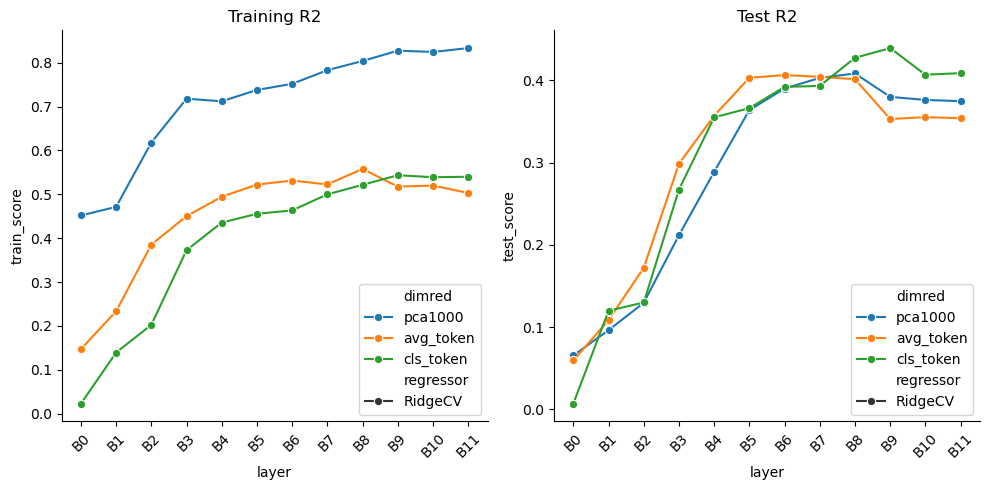

In [35]:
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=lambda x: x.replace(".transformer.resblocks.ResidualAttentionBlock", "B"))
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()

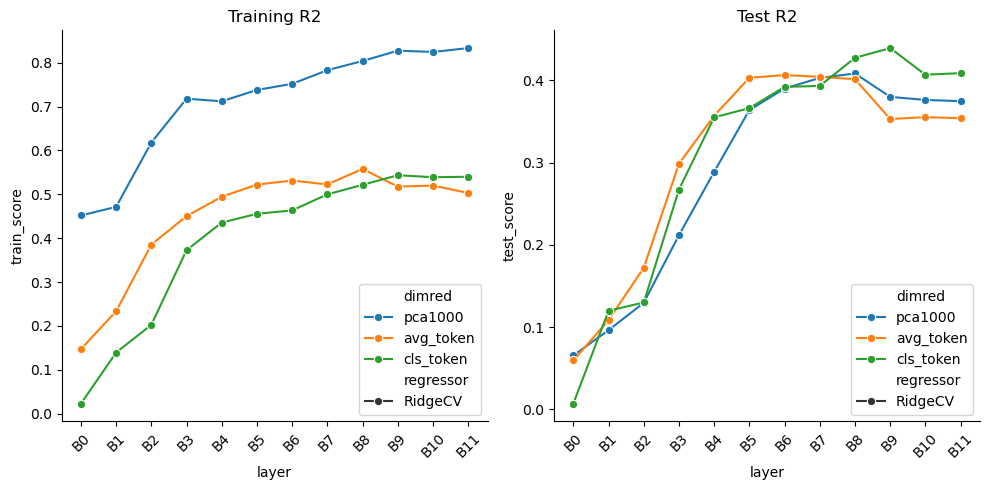

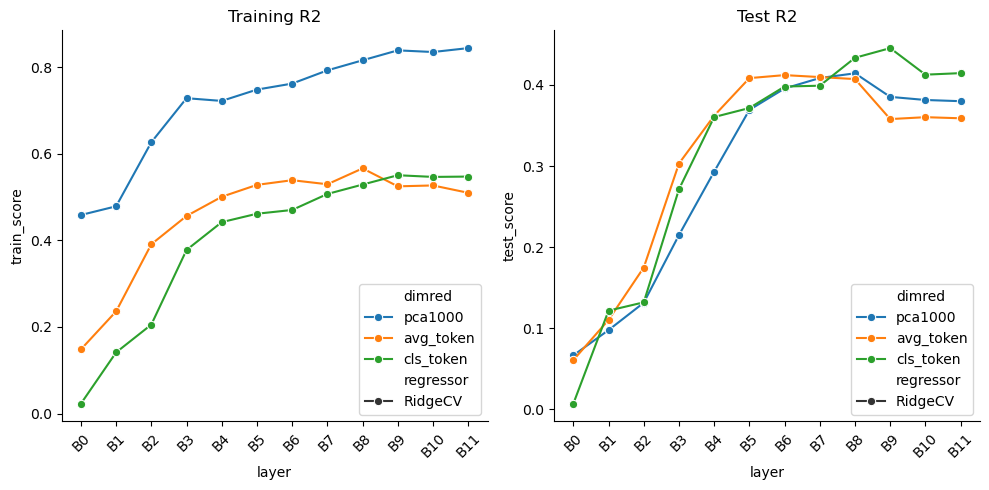

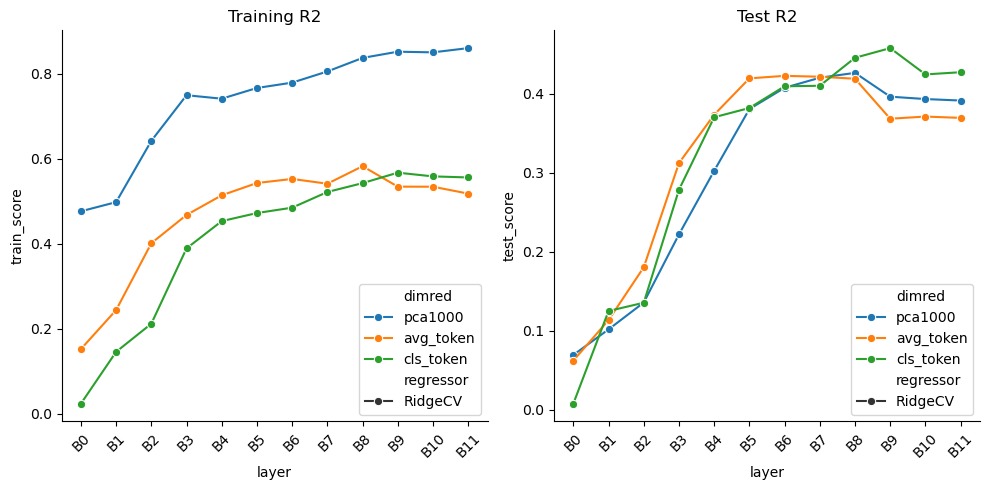

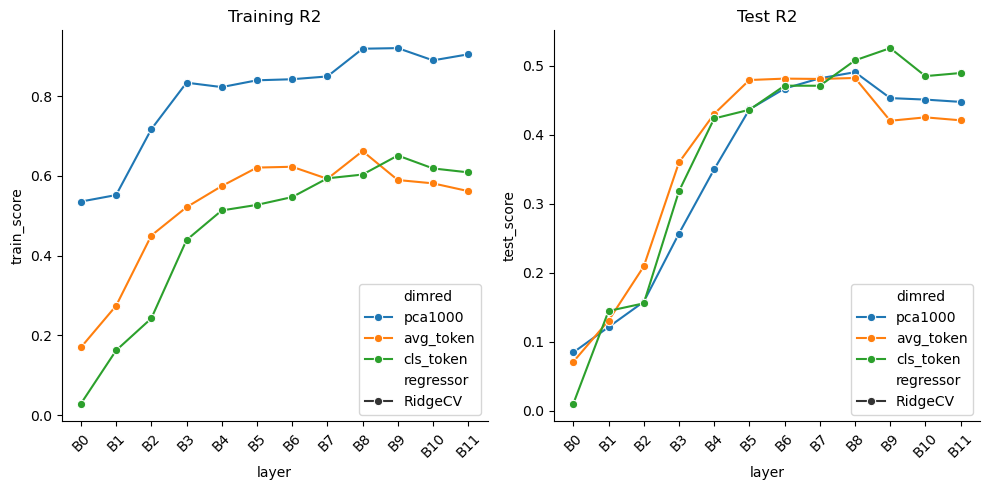

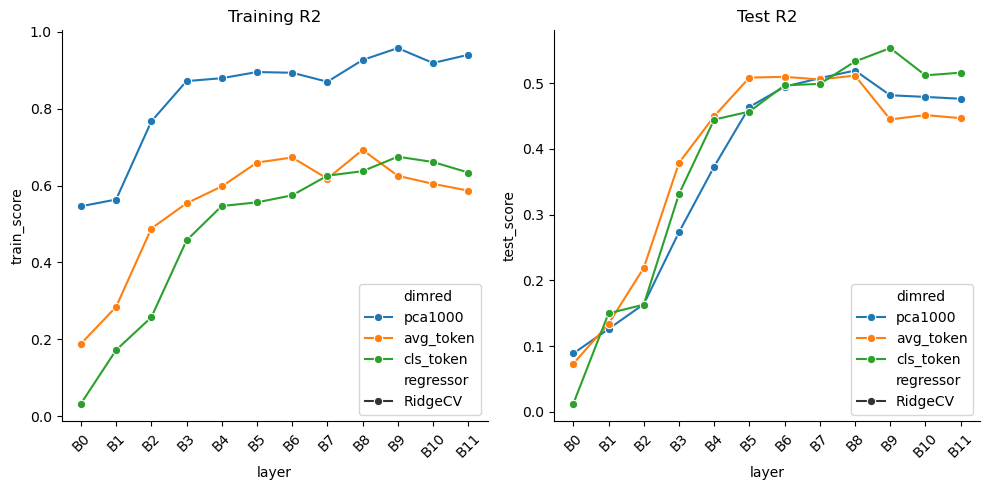

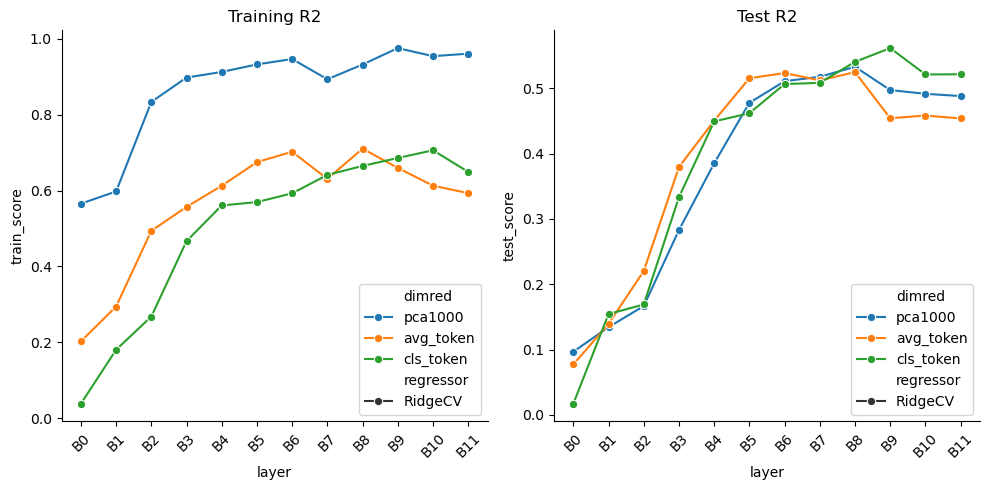

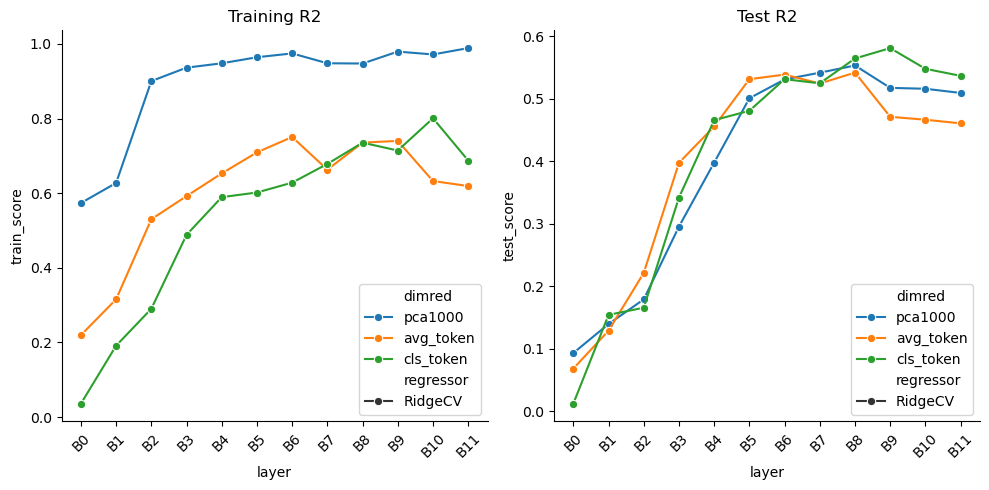

In [37]:
layer_shorten_func = lambda x: x.replace(".transformer.resblocks.ResidualAttentionBlock", "B")
figh = plot_result_df_per_layer(result_df_lyrswp, shorten_func=layer_shorten_func)
figh.suptitle(f"{subject_id} {modelname} layer sweep")
figh.tight_layout()
saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
# %%
# Mask out unreliable channels and plot again
for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
    channel_count = (reliability > thresh).sum()
    result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                pred_D2_dict['D2_per_unit_test_dict'], 
                                                mask=reliability > thresh,)
    figh = plot_result_df_per_layer(result_df_masked, shorten_func=layer_shorten_func)
    figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
    figh.tight_layout()
    figh.show()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
plt.close("all")


### Pipeline

In [ ]:
# subject_id = 'paul_240713-240710'
# for subject_id in ['paul_240713-240710', 
#                    'paul_20240713-20240710', 
#                    'red_20240713-20240710',
#                    'baby1_20240329-20240325', 
#                    'baby1_240329-240325', 
#                    'baby5_240819-240822', ]: 
#%%
batch_size = 64
# modelname = "resnet50"
device = "cuda" if torch.cuda.is_available() else "cpu"
for modelname in ["clipag_vitb32", ]: # 
    model, transforms_pipeline = load_model_transform(modelname, device=device)
    # Prepare dataset with transforms
    dataset = ImagePathDataset(image_fps, scores=resp_mat, transform=transforms_pipeline)
    # Prepare fetcher
    fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
    module_names = [name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]
    # Add hooks to all layers / blocks in resnet50
    for name in module_names: 
        fetcher.record(name, store_device='cpu', ingraph=False, )

    # Record features
    feat_dict_lyrswp = record_features(model, fetcher, dataset, batch_size=batch_size, device=device)
    fetcher.cleanup()
    th.cuda.empty_cache()
    #%%
    resp_mat_sel = resp_mat
    print(f"Fitting models for All channels N={resp_mat_sel.shape[1]}")
    # result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer(feat_dict_lyrswp, 
    #             resp_mat_sel, layer_names=module_names, # 'layer2', 'layer3', 
    #             regressor_list=["Ridge",], dimred_list=["pca1000", "srp", "srp1000", "srp2000"], verbose=True) # "sp_cent", "sp_avg", 
    result_df_lyrswp, fit_models_lyrswp, Xdict_lyrswp, Xtfmer_lyrswp = perform_regression_sweeplayer_RidgeCV(feat_dict_lyrswp, 
                resp_mat_sel, layer_names=module_names, alpha_per_target=True, 
                alpha_list=[1E-4, 1E-3, 1E-2, 1E-1, 1, 10, 100, 1E3, 1E4, 1E5, 1E6, 1E7, 1E8, 1E9],
                dimred_list=["pca1000", "srp", "srp1000",], verbose=True, use_pca_dual=True) # "sp_cent", "sp_avg", regressor_list=["Ridge",], 

    pred_D2_dict = compute_pred_dict_D2_per_unit(fit_models_lyrswp, Xdict_lyrswp, resp_mat_sel)
    pkl.dump(pred_D2_dict, 
            open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "wb"))
    result_df_lyrswp.to_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_sweep_RidgeCV.csv"))
    th.save(fit_models_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_fitmodels_RidgeCV.pth")) 
    # th.save(Xtfmer_lyrswp, join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"))
    # pkl.dump(Xtfmer_lyrswp, open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_Xtfmer_RidgeCV.pkl"), "wb"))

    # %%
    
    figh = plot_result_df_per_layer(result_df_lyrswp, )
    figh.suptitle(f"{subject_id} {modelname} layer sweep")
    figh.tight_layout()
    saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis", figh=figh)
    # %%
    # Mask out unreliable channels and plot again
    for thresh in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]:
        channel_count = (reliability > thresh).sum()
        result_df_masked = construct_result_df_masked(pred_D2_dict['D2_per_unit_train_dict'], 
                                                    pred_D2_dict['D2_per_unit_test_dict'], 
                                                    mask=reliability > thresh)
        figh = plot_result_df_per_layer(result_df_masked, )
        figh.suptitle(f"{subject_id} {modelname} layer sweep | reliable channels > {thresh} (N={channel_count})")
        figh.tight_layout()
        figh.show()
        saveallforms(figdir, f"{subject_id}_{modelname}_layer_sweep_synopisis_reliable_thresh{thresh}_masked", figh=figh)
    plt.close("all")
    

### Scratch

In [ ]:
type(model_clip.visual)
from open_clip.transformer import VisionTransformer

open_clip.transformer.VisionTransformer

In [ ]:
model.transformer.resblocks

ModuleList(
  (0-11): 12 x ResidualAttentionBlock(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
    (ls_1): Identity()
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=768, out_features=3072, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=3072, out_features=768, bias=True)
    )
    (ls_2): Identity()
  )
)

In [ ]:
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)

In [ ]:
fetcher.module_names

OrderedDict([('0', 'Image'),
             ('1', '.Conv2dconv1'),
             ('2', '.Identitypatch_dropout'),
             ('3', '.LayerNormln_pre'),
             ('4', '.transformer.resblocks.0.LayerNormln_1'),
             ('5', '.transformer.resblocks.0.MultiheadAttentionattn'),
             ('6', '.transformer.resblocks.0.Identityls_1'),
             ('7', '.transformer.resblocks.0.LayerNormln_2'),
             ('8', '.transformer.resblocks.0.mlp.Linearc_fc'),
             ('9', '.transformer.resblocks.0.mlp.GELUgelu'),
             ('10', '.transformer.resblocks.0.mlp.Linearc_proj'),
             ('11', '.transformer.resblocks.0.mlp'),
             ('12', '.transformer.resblocks.0.Identityls_2'),
             ('13', '.transformer.resblocks.ResidualAttentionBlock0'),
             ('14', '.transformer.resblocks.1.LayerNormln_1'),
             ('15', '.transformer.resblocks.1.MultiheadAttentionattn'),
             ('16', '.transformer.resblocks.1.Identityls_1'),
             ('17', 

In [ ]:
[name for name in fetcher.module_names.values() if "ResidualAttentionBlock" in name]

['.transformer.resblocks.ResidualAttentionBlock0',
 '.transformer.resblocks.ResidualAttentionBlock1',
 '.transformer.resblocks.ResidualAttentionBlock2',
 '.transformer.resblocks.ResidualAttentionBlock3',
 '.transformer.resblocks.ResidualAttentionBlock4',
 '.transformer.resblocks.ResidualAttentionBlock5',
 '.transformer.resblocks.ResidualAttentionBlock6',
 '.transformer.resblocks.ResidualAttentionBlock7',
 '.transformer.resblocks.ResidualAttentionBlock8',
 '.transformer.resblocks.ResidualAttentionBlock9',
 '.transformer.resblocks.ResidualAttentionBlock10',
 '.transformer.resblocks.ResidualAttentionBlock11']